In [1]:
import numpy as np
import pandas as pd
import os

datadir = os.path.join('..', 'WISDM_at_v2.0')
raw_headers = ['user','activity','time','x','y','z']
act_headers = ['user','X0','X1','X2','X3','X4','X5','X6','X7','X8','X9','Y0','Y1','Y2','Y3','Y4','Y5','Y6','Y7','Y8','Y9','Z0','Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','XAVG','YAVG','ZAVG','XPEAK','YPEAK','ZPEAK','XABSOLDEV', 'YABSOLDEV','ZABSOLDEV','XSTANDDEV','YSTANDDEV','ZSTANDDEV','Resultant','Activity']


In [68]:
labelled_act = os.path.join(datadir,'WISDM_at_v2.0_transformed.csv')
labelled_raw = os.path.join(datadir, 'WISDM_at_v2.0_raw.txt')
unlabelled_act = os.path.join(datadir,'WISDM_at_v2.0_unlabeled_transformed.csv')
unlabelled_raw = os.path.join(datadir, 'WISDM_at_v2.0_unlabeled_raw.txt')
raw_data = pd.read_csv(unlabelled_raw, header=None, names = raw_headers, parse_dates=True)
act_data = pd.read_csv(unlabelled_act, header=None, names = act_headers) 
lab_raw = pd.read_csv(labelled_raw, header=None, names = raw_headers, parse_dates=True)
lab_act = pd.read_csv(labelled_act, header=None, names = act_headers)

In [69]:
print "concat raw"
#raw_data = pd.concat([unlabelled_raw_data, raw_data])
#raw_data = unlabelled_raw_data
#act_data = unlabelled_act_data
#del unlabelled_raw_data
print "concat act"
#act_data = pd.concat([unlabelled_act_data, act_data])
#del unlabelled_act_data
print "concat over"

lab_raw = lab_raw.loc[lab_raw['time']>0]
lab_raw['time'] = pd.to_datetime(lab_raw['time'], unit = 'ms', errors='coerce')
raw_data = raw_data.loc[raw_data['time']>0]
raw_data['time'] = pd.to_datetime(raw_data['time'], unit = 'ms', errors='coerce')

concat raw
concat act
concat over


In [ ]:
#users in unlabelled set
users = list(set(raw_data.user.unique()).intersection(set(act_data.user.unique())))
print len(users)
time_user_raw = raw_data[['user','time']]
user_duration = time_user_raw.groupby('user').agg({'time':[min,max]})
user_duration.columns = ["_".join(x) for x in user_duration.columns.ravel()]
user_duration['duration'] = user_duration['time_max'] - user_duration['time_min']
#print user_duration.sort_values(by='duration').loc[act_data.user.unique()]['duration']
user_duration = user_duration.loc[users]
user_duration = user_duration[(user_duration['duration'].dt.total_seconds()) > 7200]
#users in labelled set
lab_users = list(set(lab_raw.user.unique()).intersection(set(lab_act.user.unique())))
#common users
comm_users = list(set(lab_users).intersection(set(users)))

time_user_raw_l = lab_raw[['user','time']]
time_user_raw_l = time_user_raw_l.loc[time_user_raw_l['user'].isin(comm_users)]
user_duration_l = time_user_raw_l.groupby('user').agg({'time':[min,max]})
user_duration_l.columns = ["_".join(x) for x in user_duration_l.columns.ravel()]
user_duration_l['duration'] = user_duration_l['time_max'] - user_duration_l['time_min']
user_duration_l = user_duration_l[(user_duration_l['duration'].dt.total_seconds()) > 7200]

#remove common users with overlapping durations
overlapped = []
for usr in comm_users:
    lstime = user_duration_l.loc[user_duration_l.index==usr]['time_min'].values
    letime = user_duration_l.loc[user_duration_l.index==usr]['time_max'].values
    stime = user_duration.loc[user_duration.index==usr]['time_min'].values
    etime = user_duration.loc[user_duration.index==usr]['time_max'].values
    #print lstime,letime, stime, etime
    if (lstime>stime and lstime<etime) or (letime>stime and letime<etime) or (lstime<stime and letime>etime):
        overlapped.append(usr)

all_users = users
users = [usr for usr in all_users if (usr not in overlapped) and ((usr in user_duration.index) or (usr in user_duration_l.index))]

#filter all suitable users from labelled and unlabelled set and concat
unlabelled_raw_data = raw_data.loc[raw_data['user'].isin(users)]
unlabelled_act_data = act_data.loc[act_data['user'].isin(users)]
labelled_raw_data = lab_raw.loc[lab_raw['user'].isin(users)]
labelled_act_data = lab_act.loc[lab_act['user'].isin(users)]

raw_data = pd.concat([labelled_raw_data,unlabelled_raw_data])
del labelled_raw_data
del unlabelled_raw_data
act_data = pd.concat([labelled_act_data, unlabelled_act_data])
del labelled_act_data
del unlabelled_act_data

#print user_duration.sort_values(by='duration')['duration']
#users = user_duration.index

143


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


In [71]:
print users
activity_duration = {'Walking': 0, 'Jogging': 1, 'Standing': 2, 'Sitting': 3, 'Stairs': 4, 'LyingDown': 5}
user_feats = []
#users = []
nan_users = {}
for userid in users:
    user_act_data = act_data.loc[act_data['user']==userid]['Activity']
    prev = user_act_data.iloc[0]
    #feat = [walk_dur, jog_dur, stand_dur, sit_dur, stair_dur, ly_dur, no_tx, walk_jog, walk_sit, sit_walk]
    feat = [0.0]*7
    txfeat = [0.0]*36
    tot_dur = 0
    for i,activity in user_act_data.iteritems():
        
        if activity_duration.get(activity, -1)==-1:
            nan_users[userid] = i        
            print userid, activity
        feat_index = activity_duration.get(activity, -1)
        if feat_index != -1:
            #print activity
            feat[feat_index] = feat[feat_index] + 1
            if activity!= prev:
                feat[6] = feat[6] + 1
                pfeat_index = activity_duration.get(activity)
                index = (6*pfeat_index)+feat_index
                txfeat[index] = txfeat[index]+1
            prev = activity
        #else:
            #print userid, activity
        tot_dur = tot_dur + 1
    dfeat = [x/tot_dur for x in feat[:-1] ]
    if feat[6]!=0:
        txfeat = [x/feat[6] for x in txfeat ]
    ufeat = dfeat+txfeat
    user_feats.append(ufeat)
    print ufeat
    #users.append(userid)


[1537, 1550, 1556, 1058, 1064, 1577, 1804, 1104, 1634, 1647, 1140, 1664, 1685, 1696, 1702, 1191, 1193, 1736, 1726, 1732, 1233, 1748, 1749, 1239, 1753, 1758, 1769, 1266, 1791, 1793, 1801, 1802, 1294, 1314, 1763, 925, 1745, 1783, 1484, 1491, 1498, 1501, 1512, 1704, 1526]
[0.06666666666666667, 0.0, 0.0, 0.9333333333333333, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.02773801002147459, 0.0, 0.0613815318539728, 0.41070150322118826, 0.004473872584108805, 0.49570508231925553, 0.29646017699115046, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2345132743362832, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23893805309734514, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.09292035398230089, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13716814159292035]
[0.027573142496316566, 0.0, 0.011155546200799832, 0.7902546832245843, 0.002420543043569775, 0.16859608503472953, 0.315

[0.9983681081711155, 0.0, 0.0, 0.0016318918288844855, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.8022243713733076, 0.0, 0.0038684719535783366, 0.049806576402321084, 0.004352030947775629, 0.13974854932301742, 0.17054263565891473, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03875968992248062, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3953488372093023, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023255813953488372, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.37209302325581395]
[0.0, 0.01207115628970775, 0.30241423125794153, 0.3850063532401525, 0.2795425667090216, 0.02096569250317662, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.021739130434782608, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.286231884057971, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.39855072463768115, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20652173913043478, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08695652173913043]
[0.03361721201

In [13]:
activity_duration.keys()

['Standing', 'Walking', 'Sitting', 'Jogging', 'LyingDown', 'Stairs']

In [6]:
for userid in users:
    user_act_data = act_data.loc[act_data['user']==userid]['Activity']
    print user_act_data.head()

5033    Standing
5034    Standing
5035    Standing
5036    Standing
5037    Standing
Name: Activity, dtype: object
5139    Stairs
5140    Stairs
5141    Stairs
5142    Stairs
5143    Stairs
Name: Activity, dtype: object
5148    Sitting
5149    Sitting
5150    Sitting
5151    Sitting
5152    Sitting
Name: Activity, dtype: object
5332     Walking
5333    Standing
5334     Sitting
Name: Activity, dtype: object
3885    Standing
3886    Standing
3887    Standing
3888    Standing
3889    Standing
Name: Activity, dtype: object
3165    Walking
3166    Walking
3167    Walking
3168    Walking
3169    Walking
Name: Activity, dtype: object
3201    Walking
3202    Walking
3203    Walking
3204    Walking
3205    Walking
Name: Activity, dtype: object
3987    Sitting
3988    Sitting
3989    Sitting
3990    Sitting
3991    Sitting
Name: Activity, dtype: object
1979    Walking
1980    Walking
1981    Walking
1982    Walking
1983    Walking
Name: Activity, dtype: object
2550    Sitting
2551    Sitting
25

In [72]:
print users
print len(users)
print len(user_feats)
ufeats = np.array(user_feats)
print ufeats

[1537, 1550, 1556, 1058, 1064, 1577, 1804, 1104, 1634, 1647, 1140, 1664, 1685, 1696, 1702, 1191, 1193, 1736, 1726, 1732, 1233, 1748, 1749, 1239, 1753, 1758, 1769, 1266, 1791, 1793, 1801, 1802, 1294, 1314, 1763, 925, 1745, 1783, 1484, 1491, 1498, 1501, 1512, 1704, 1526]
45
45
[[0.06666667 0.         0.         ... 0.         0.         0.        ]
 [0.02773801 0.         0.06138153 ... 0.         0.         0.13716814]
 [0.02757314 0.         0.01115555 ... 0.         0.         0.24014337]
 ...
 [0.06412402 0.0044922  0.11265745 ... 0.         0.         0.33865248]
 [0.00199867 0.         0.         ... 0.         0.         0.48888889]
 [0.00596529 0.00878525 0.08633406 ... 0.         0.         0.21709975]]


In [10]:
for userid in users:
    user_raw_data = raw_data.loc[raw_data['user']==userid]
    prev_time = user_raw_data.iloc[0]['time']
    gap = 0
    print userid, 'GAP LENGTHS'
    for index, attr in user_raw_data.iterrows():
        tgap = (attr[2] - prev_time).total_seconds()
        if  tgap > 120:
            gap = gap + 1
            print tgap//60, 'min..i.e.', tgap,'s'
        prev_time = attr[2]
    print '#gaps:',gap


1793 GAP LENGTHS
#gaps: 0
1797 GAP LENGTHS
76.0 min..i.e. 4582.593 s
46.0 min..i.e. 2805.907 s
7377.0 min..i.e. 442663.949 s
#gaps: 3
1799 GAP LENGTHS
#gaps: 0
1802 GAP LENGTHS
#gaps: 0
1676 GAP LENGTHS
3.0 min..i.e. 228.818 s
2.0 min..i.e. 150.086 s
2.0 min..i.e. 131.435 s
3.0 min..i.e. 189.806 s
2.0 min..i.e. 120.832 s
#gaps: 5
1554 GAP LENGTHS
67.0 min..i.e. 4030.947 s
#gaps: 1
1559 GAP LENGTHS
2.0 min..i.e. 121.058 s
#gaps: 1
1696 GAP LENGTHS
60.0 min..i.e. 3640.478 s
6.0 min..i.e. 419.638 s
3.0 min..i.e. 224.02 s
#gaps: 3
1319 GAP LENGTHS
2196.0 min..i.e. 131802.585 s
11.0 min..i.e. 682.179 s
230725.0 min..i.e. 13843552.625 s
52.0 min..i.e. 3179.215 s
6.0 min..i.e. 377.36 s
2.0 min..i.e. 165.488 s
2.0 min..i.e. 122.868 s
#gaps: 7
1320 GAP LENGTHS
20.0 min..i.e. 1212.988 s
15.0 min..i.e. 924.604 s
23023.0 min..i.e. 1381421.167 s
#gaps: 3
1707 GAP LENGTHS
1614.0 min..i.e. 96842.892 s
57695.0 min..i.e. 3461723.944 s
7.0 min..i.e. 434.037 s
1168.0 min..i.e. 70136.07 s
#gaps: 4
1117 GA

In [19]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_validate

for n in range(2,10):
    gmm = GaussianMixture(n_components=n)
    cv_results = cross_validate(gmm, user_feats, cv=10,  return_train_score=False)
    print n, cv_results

ImportError: cannot import name _k_means

Text(0.5,0,u'n_components')

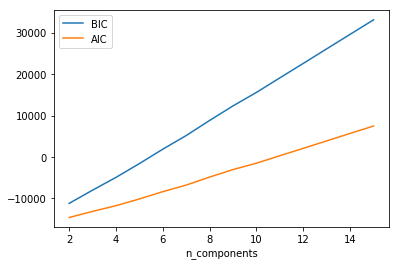

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
n_components = range(2,16)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(ufeats) for n in n_components]
plt.plot(n_components, [m.bic(ufeats) for m in models], label='BIC')
plt.plot(n_components, [m.aic(ufeats) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [74]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
db = DBSCAN(eps=0.3).fit(ufeats)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
db_labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(ufeats, db_labels))

Estimated number of clusters: 4
Silhouette Coefficient: 0.088


In [50]:
#cluster characteristics when 5 clusters for GMM and 3 for DBSCAN
gmm = GaussianMixture(13, covariance_type='full', random_state=0).fit(ufeats)
user_labels_gmm = gmm.predict(ufeats)
print user_labels_gmm

def indices( mylist, value):
    return [i for i,x in enumerate(mylist) if x==value]

gmm_clusters = {}
for n in range(13):
   gmm_clusters[n] = indices(user_labels_gmm, n)
    
#dbscan clusters
db_clusters = {}
for n in range(2):
    db_clusters[n] = indices(db_labels, n)

print 'gmm:', gmm_clusters
print 'db:',db_clusters

[ 9  3 10  8  1  4  3  9  0  2  6  7  6  3  4 10  8  4  2 10  6  8  1  6
 10 10 10  0  5  6  6  2 10  2  2  6  6  6  2 10  2  2  9  5  0 10  1 10
 11  6  8  7  8 11  7 12 11  5  1  0  8  3  0  3  3  9  5  0  5  3  5  3
 11  0  5  3  5  0  5  0  5  5  0  3 12  7 11  7  5  8 11  5  0  0  5  5
  5  0  0  9  2 11  8  4  4 12  1 11  4  4  3  4 11 11 11  3  4  1 11  2
 11  4  5  2]
gmm: {0: [8, 27, 44, 59, 62, 67, 73, 77, 79, 82, 92, 93, 97, 98], 1: [4, 22, 46, 58, 106, 117], 2: [9, 18, 31, 33, 34, 38, 40, 41, 100, 119, 123], 3: [1, 6, 13, 61, 63, 64, 69, 71, 75, 83, 110, 115], 4: [5, 14, 17, 103, 104, 108, 109, 111, 116, 121], 5: [28, 43, 57, 66, 68, 70, 74, 76, 78, 80, 81, 88, 91, 94, 95, 96, 122], 6: [10, 12, 20, 23, 29, 30, 35, 36, 37, 49], 7: [11, 51, 54, 85, 87], 8: [3, 16, 21, 50, 52, 60, 89, 102], 9: [0, 7, 42, 65, 99], 10: [2, 15, 19, 24, 25, 26, 32, 39, 45, 47], 11: [48, 53, 56, 72, 86, 90, 101, 107, 112, 113, 114, 118, 120], 12: [55, 84, 105]}
db: {0: [2, 9, 16, 18, 21, 24, 25, 26

In [51]:
for cluster in gmm_clusters.keys():
    users_in_cluster = gmm_clusters[cluster]
    print 'CLUSTER ', cluster
    for u in users_in_cluster:
        print users[u],':',user_feats[u]
        
print 'DBSCAN'
for cluster in db_clusters.keys():
    users_in_cluster = db_clusters[cluster]
    print 'CLUSTER ', cluster
    for u in users_in_cluster:
        print users[u],':',user_feats[u]

CLUSTER  0
1558 : [0.48454636091724823, 0.0009970089730807576, 0.08673978065802593, 0.4187437686939183, 0.005982053838484547, 0.0029910269192422734, 0.42567567567567566, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0022522522522522522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12612612612612611, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.42567567567567566, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013513513513513514, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006756756756756757]
1140 : [0.915680473372781, 0.0, 0.0, 0.08431952662721894, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1193 : [0.9132842788195269, 1.9780045889706464e-05, 0.0, 0.08669594113458343, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005991611743559018, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4994008388256441, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
1233 : [0.985488958990

Int64Index([ 194, 1104, 1117, 1238, 1253, 1277, 1319, 1320, 1491, 1512, 1531,
            1559, 1603, 1696, 1703, 1707, 1723, 1724, 1726, 1742, 1745, 1750,
            1758, 1759, 1763, 1774, 1775, 1778, 1793, 1802],
           dtype='int64', name=u'user')


In [55]:
user_duration.duration.describe()

count                            80
mean       381 days 08:20:48.424200
std       2258 days 15:56:02.395706
min          0 days 00:07:30.039000
25%          0 days 01:48:35.751250
50%          1 days 11:50:55.782500
75%         28 days 12:57:02.119000
max      15980 days 04:16:40.466000
Name: duration, dtype: object